In [1]:
pip install matplotlib pandas -q
pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/rocm6.0/ -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import triton
import triton.language as tl

In [2]:
k = (2.0 / torch.pi) ** 0.5

In [8]:
@triton.jit  # Decorator for Triton Just-In-Time compilation
def gelu_kernel(
    output_buffer,
    input_buffer,
    input_row_stride,
    output_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    """
    Function for applying the GeLU using Triton.

    Parameters
    ----------
    output_buffer (pointer): Pointer to the buffer storing the output tensor data.
    input_buffer (pointer): Pointer to the buffer storing the input tensor data.
    input_row_stride (int): Stride (number of elements to skip) between rows in the input tensor.
    output_row_stride (int): Stride (number of elements to skip) between rows in the output tensor.
    n_cols (int): Number of columns in both the input and output tensors.
    block_size (tl.constexpr int): Block size for efficient processing of the tensors (known at compile time).

    Returns: None, output tensor buffer is modified in-place.
    """
    # Determine the starting row pointer based on program ID
    row_idx = tl.program_id(0)
    row_start_ptr = input_buffer + row_idx * input_row_stride

    # Generate a range of column offsets for block processing
    col_offsets = tl.arange(0, block_size)
    input_ptrs = row_start_ptr + col_offsets

    # Load the current row of data, handling potential out-of-bounds elements
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))

    # Apply the GELU activation function using a tanh approximation
    t = (row + 0.044715 * row * row * row) * k
    numerator = 2
    denominator = (1 + tl.exp(-2 * t))
    gelu_output = 0.5 * row * (1 + (numerator / denominator) - 1)

    # Calculate output pointers and store the calculated GELU values
    output_row_start_ptr = output_buffer + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, gelu_output, mask=col_offsets < n_cols)

In [9]:
def gelu(x: torch.Tensor):
    n_rows, n_cols = x.shape

    # Determine an efficient block size for processing elements in parallel on the GPU
    block_size = triton.next_power_of_2(n_cols)

    # Adjust the number of warps (thread groups) based on block size for optimal performance
    # Use 4 warps for smaller block sizes
    num_warps = 4
    
    # Increase to 8 warps for larger blocks
    if block_size >= 2048:
        num_warps = 8
    
    # Further increase to 16 warps for even larger blocks
    elif block_size >= 4096:
        num_warps = 16

    y = torch.empty_like(x)

    gelu_kernel[(n_rows,)](# Launch with a one-element tuple for grid size (number of rows)
      y,  # Output tensor
      x,  # Input tensor
      x.stride(0),  # Stride between rows in the input tensor
      y.stride(0),  # Stride between rows in the output tensor
      n_cols,  # Number of columns in the tensors
      num_warps=num_warps,  # Number of warps for parallel execution
      block_size=block_size,  # Block size for efficient processing
    )

    return y

In [14]:
torch.manual_seed(0)
x = torch.randn(4097, 311, device='cuda')
y_triton = gelu(x)
y_torch = torch.nn.functional.gelu(x, approximate='tanh')
assert torch.allclose(y_triton, y_torch, rtol=1e-04,atol=1e-04), (y_triton, y_torch)

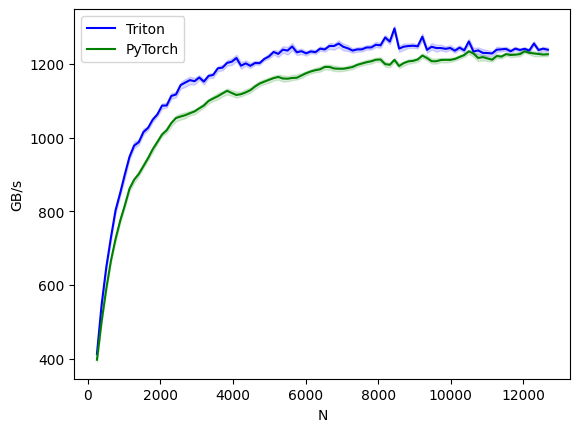

gelu-performance:
          N       Triton      PyTorch
0     256.0   412.825194   397.187867
1     384.0   546.133325   500.912113
2     512.0   647.269138   589.087624
3     640.0   728.177790   665.340068
4     768.0   802.481623   724.822122
..      ...          ...          ...
93  12160.0  1235.914626  1229.811354
94  12288.0  1255.153292  1228.196495
95  12416.0  1237.370733  1226.626532
96  12544.0  1241.066412  1225.088796
97  12672.0  1238.180187  1225.894135

[98 rows x 3 columns]


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'pytorch',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "PyTorch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="gelu-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.nn.functional.gelu(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: gelu(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(show_plots=True, print_data=True)